Generated sim_target with shape: torch.Size([8, 256, 50])
Generated gaussian_map with shape: torch.Size([16, 16])


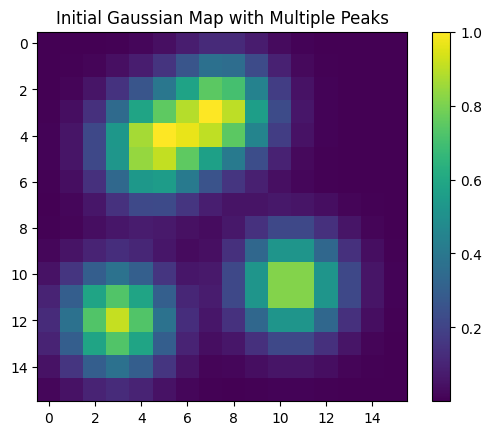

Initial sim_target shape: torch.Size([8, 256, 50])
Computed map_size: 16, num_heads: 8, num_tokens: 50
sim_target reshaped to: torch.Size([8, 50, 16, 16])
Gaussian map after unsqueeze: torch.Size([1, 1, 16, 16])
Mask shape: torch.Size([1, 16, 16])
sim_token_1 shape before applying Gaussian map: torch.Size([8, 16, 16])
sim_token_1 shape after applying Gaussian map: torch.Size([8, 16, 16])
sim_tokens_after_14 shape before applying Gaussian map: torch.Size([8, 35, 16, 16])
sim_tokens_after_14 shape after applying Gaussian map: torch.Size([8, 35, 16, 16])
sim_target reshaped back to original shape: torch.Size([8, 256, 50])


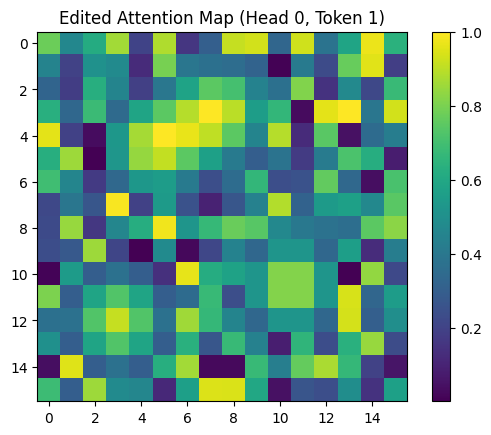

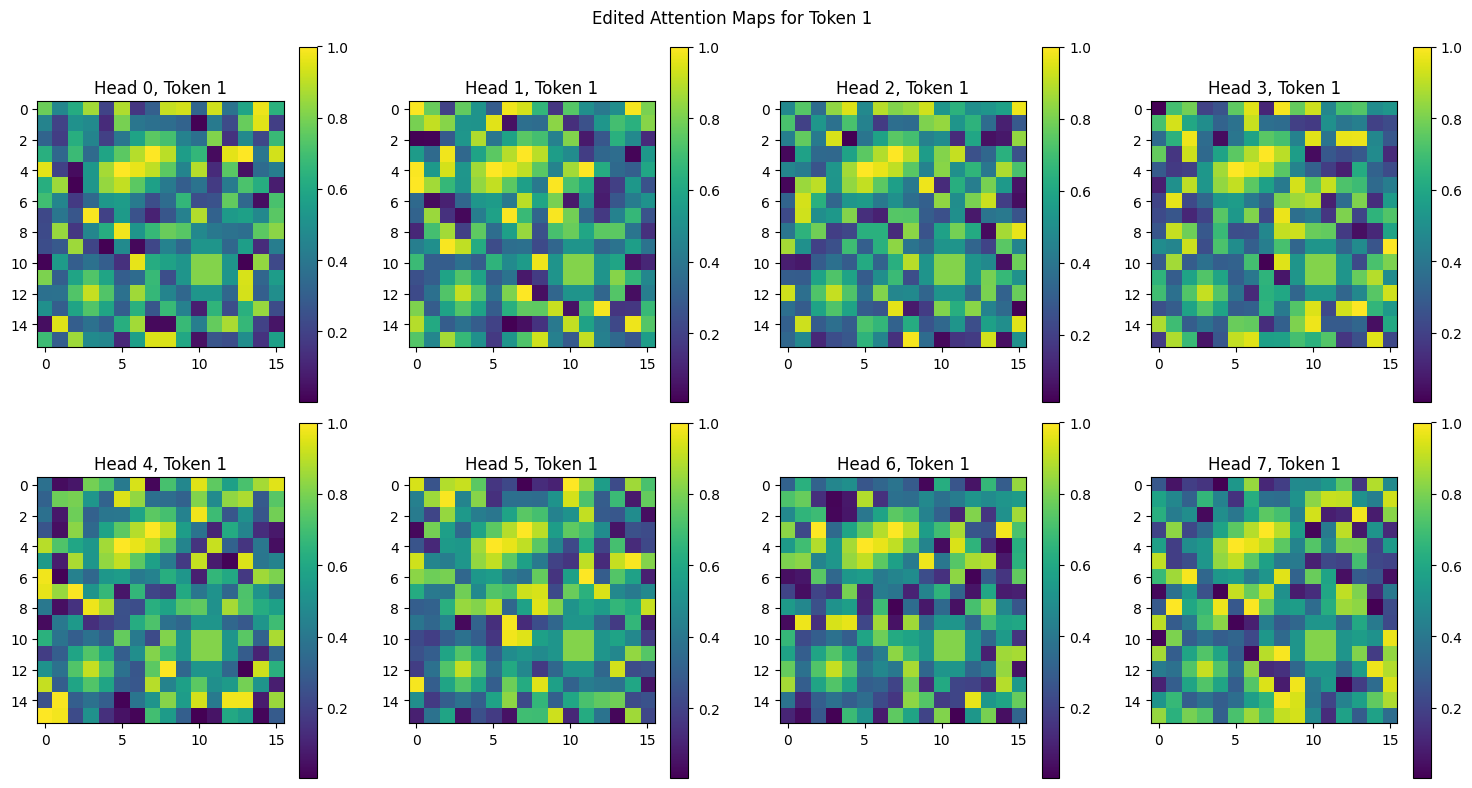

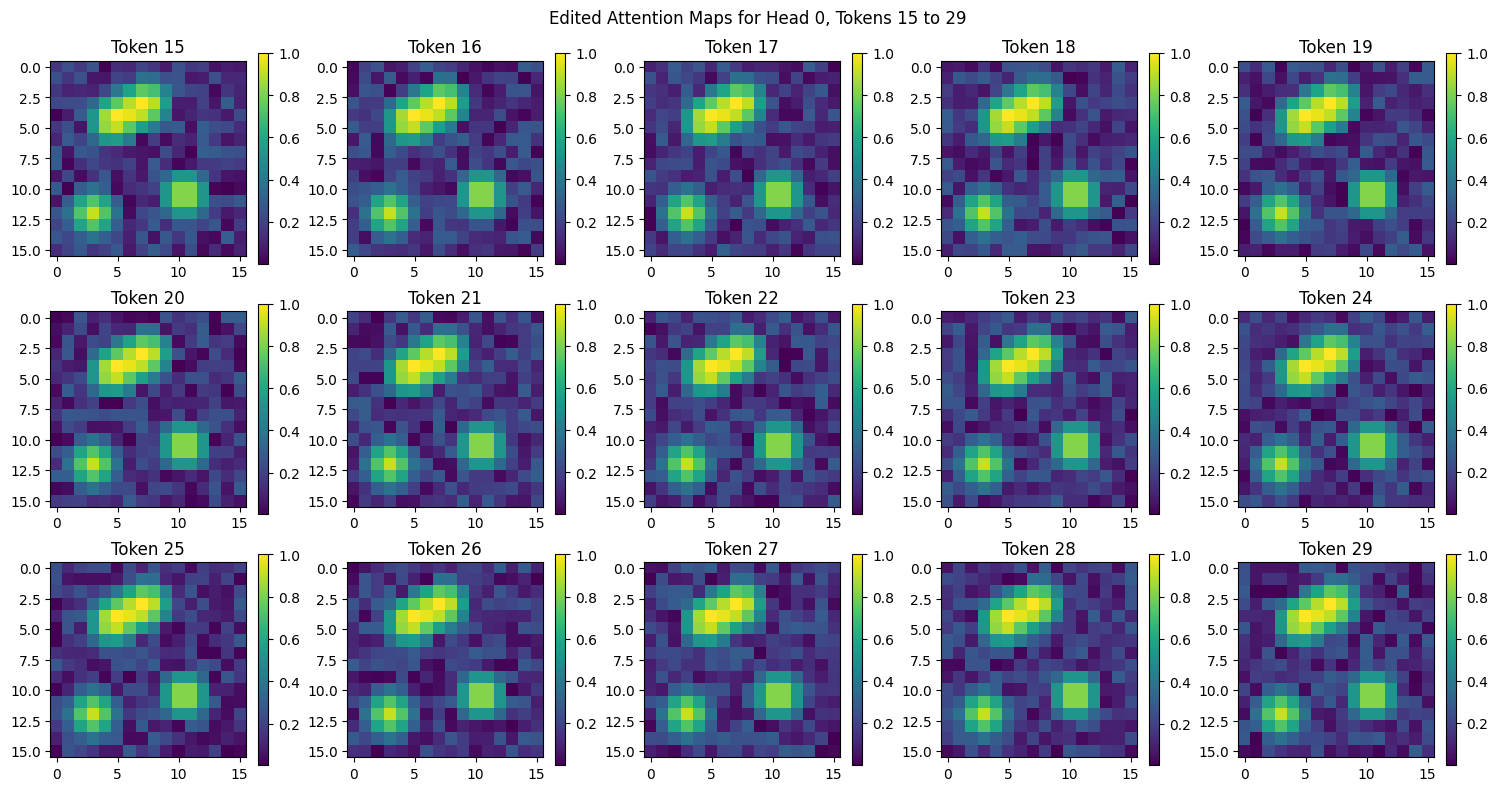

In [2]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Function to apply attention edit
def apply_attention_edit(sim_target, gaussian_map, alpha=0.3):
    map_size = int(math.sqrt(sim_target.shape[1]))
    num_heads = sim_target.shape[0]
    num_tokens = sim_target.shape[2]
    print(f"Initial sim_target shape: {sim_target.shape}")
    print(f"Computed map_size: {map_size}, num_heads: {num_heads}, num_tokens: {num_tokens}")

    # Reshape sim_target to (num_heads, map_size, map_size, num_tokens)
    sim_target = sim_target.view(num_heads, map_size, map_size, num_tokens).permute(0, 3, 1, 2)
    print(f"sim_target reshaped to: {sim_target.shape}")

    # Prepare the Gaussian map
    gaussian_map = gaussian_map.unsqueeze(0).unsqueeze(0)
    print(f"Gaussian map after unsqueeze: {gaussian_map.shape}")
    if gaussian_map.shape[2:] != (map_size, map_size):
        gaussian_map = nn.functional.interpolate(
            gaussian_map, size=(map_size, map_size), mode='bilinear', align_corners=False
        )
        print(f"Gaussian map after interpolation: {gaussian_map.shape}")

    # Create a mask where the Gaussian map has values greater than 0.3
    mask = gaussian_map.squeeze(0) > 0.3
    print(f"Mask shape: {mask.shape}")

    # Apply the Gaussian map only where the mask is True for token 1
    sim_token_1 = sim_target[:, 1, :, :]  # Get token 1
    print(f"sim_token_1 shape before applying Gaussian map: {sim_token_1.shape}")
    sim_token_1 = torch.where(mask, gaussian_map.squeeze(0), sim_token_1)  # Apply Gaussian where mask is True
    sim_target[:, 1, :, :] = sim_token_1  # Place it back into sim_target
    print(f"sim_token_1 shape after applying Gaussian map: {sim_token_1.shape}")

    # Apply the Gaussian map only where the mask is True for tokens after the 14th token
    sim_tokens_after_14 = sim_target[:, 15:, :, :]
    print(f"sim_tokens_after_14 shape before applying Gaussian map: {sim_tokens_after_14.shape}")
    # Expand mask and gaussian_map to match sim_tokens_after_14 dimensions
    mask_expanded = mask.unsqueeze(1)
    gaussian_map_expanded = gaussian_map.squeeze(0).unsqueeze(1)
    sim_tokens_after_14 = torch.where(mask_expanded, gaussian_map_expanded, sim_tokens_after_14 * alpha)
    sim_target[:, 15:, :, :] = sim_tokens_after_14
    print(f"sim_tokens_after_14 shape after applying Gaussian map: {sim_tokens_after_14.shape}")

    # Reshape back to the original shape (num_heads, dimensions, num_tokens)
    sim_target = sim_target.permute(0, 2, 3, 1).view(num_heads, -1, num_tokens)
    print(f"sim_target reshaped back to original shape: {sim_target.shape}")

    return sim_target

# Sample data generation
num_heads = 8
map_size = 16  # Assuming map_size x map_size
num_tokens = 50  # Total number of tokens
sim_target = torch.rand(num_heads, map_size * map_size, num_tokens)
print(f"Generated sim_target with shape: {sim_target.shape}")

# Generate a Gaussian map with multiple peaks
def create_multiple_gaussian_map(size, centers, sigma=1):
    """
    Create a 2D map with multiple Gaussian peaks.
    :param size: Size of the map (size x size)
    :param centers: List of (x, y) tuples where the Gaussians are centered (values between 0 and 1)
    :param sigma: Standard deviation of the Gaussians
    :return: Torch tensor of the Gaussian map
    """
    x = np.linspace(0, 1, size)
    y = np.linspace(0, 1, size)
    xv, yv = np.meshgrid(x, y)
    gaussian_map = np.zeros((size, size))
    for center in centers:
        cx, cy = center
        gaussian = np.exp(-(((xv - cx)**2 + (yv - cy)**2) / (2 * sigma**2)))
        gaussian_map += gaussian
    # Normalize the map to have values between 0 and 1
    gaussian_map = gaussian_map / np.max(gaussian_map)
    return torch.tensor(gaussian_map, dtype=torch.float32)

# Define centers for multiple Gaussians (positions between 0 and 1)
gaussian_centers = [(0.3, 0.3), (0.7, 0.7), (0.5, 0.2), (0.2, 0.8)]
gaussian_map = create_multiple_gaussian_map(map_size, gaussian_centers, sigma=0.1)
print(f"Generated gaussian_map with shape: {gaussian_map.shape}")

# Visualize the initial Gaussian map with multiple peaks
plt.imshow(gaussian_map.numpy(), cmap='viridis')
plt.title('Initial Gaussian Map with Multiple Peaks')
plt.colorbar()
plt.show()

# Apply the attention edit
sim_target_edited = apply_attention_edit(sim_target, gaussian_map, alpha=0.3)

# Visualize one of the attention maps after editing
# Let's visualize the attention map of the first head and token 1
attention_map = sim_target_edited[0, :, 1].view(map_size, map_size).detach().numpy()

plt.imshow(attention_map, cmap='viridis')
plt.title('Edited Attention Map (Head 0, Token 1)')
plt.colorbar()
plt.show()

# Optionally, visualize all attention maps for head 0 and tokens 1 and after the 14th token
# Visualize attention maps for all heads for token 1
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for i in range(num_heads):
    attention_map = sim_target_edited[i, :, 1].view(map_size, map_size).detach().numpy()
    ax = axes[i // 4, i % 4]
    im = ax.imshow(attention_map, cmap='viridis')
    ax.set_title(f'Head {i}, Token 1')
    fig.colorbar(im, ax=ax)
plt.suptitle('Edited Attention Maps for Token 1')
plt.tight_layout()
plt.show()

# Visualize attention maps for head 0 and tokens after the 14th
fig, axes = plt.subplots(3, 5, figsize=(15, 8))
for idx, token_idx in enumerate(range(15, 30)):
    attention_map = sim_target_edited[0, :, token_idx].view(map_size, map_size).detach().numpy()
    ax = axes[idx // 5, idx % 5]
    im = ax.imshow(attention_map, cmap='viridis')
    ax.set_title(f'Token {token_idx}')
    fig.colorbar(im, ax=ax)
plt.suptitle('Edited Attention Maps for Head 0, Tokens 15 to 29')
plt.tight_layout()
plt.show()
